In [1]:
########### 세그멘테이션 데이터세트
import os
import json
import torch
import numpy as np
from PIL import Image
from torch.utils.data import Dataset


class SegmentationDataset(Dataset):
    def __init__(self, root, train, transform=None, target_transform=None):
        super().__init__()
        self.root = os.path.join(root, "VOCdevkit", "VOC2012")
        file_type = "train" if train else "val"
        file_path = os.path.join(
            self.root, "ImageSets", "Segmentation", f"{file_type}.txt"
        )
        with open(os.path.join(self.root, "classes.json"), "r") as file:
            self.categories = json.load(file)
        self.files = open(file_path).read().splitlines()
        self.transform = transform
        self.target_transform = target_transform
        self.data = self._load_data()
        

    def _load_data(self):
        data = []
        for file in self.files:
            image_path = os.path.join(self.root, "JPEGImages", f"{file}.jpg")
            mask_path = os.path.join(self.root, "SegmentationClass", f"{file}.png")
            image = Image.open(image_path).convert("RGB")
            mask = np.array(Image.open(mask_path))
            mask = np.where(mask == 255, 0, mask)
            target = torch.LongTensor(mask).unsqueeze(0)
            data.append([image, target])
        return data

    def __getitem__(self, index):
        image, mask = self.data[index]
        if self.transform is not None:
            image = self.transform(image)
        if self.target_transform is not None:
            mask = self.target_transform(mask)
        return image, mask

    def __len__(self):
        return len(self.data)

In [2]:
########### 데이터로더
from torchvision import transforms
from torch.utils.data import DataLoader


transform = transforms.Compose(
    [
        transforms.PILToTensor(),
        transforms.ConvertImageDtype(dtype=torch.float),
        transforms.Resize(size=(224, 224))
    ]
)
target_transform = transforms.Compose(
    [
        transforms.Resize(
            size=(224, 224),
            interpolation=transforms.InterpolationMode.NEAREST
        )
    ]
)

train_dataset = SegmentationDataset(
    "../datasets", train=True, transform=transform, target_transform=target_transform
)
test_dataset = SegmentationDataset(
    "../datasets", train=False, transform=transform, target_transform=target_transform
)

train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=True, drop_last=True)

/opt/homebrew/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


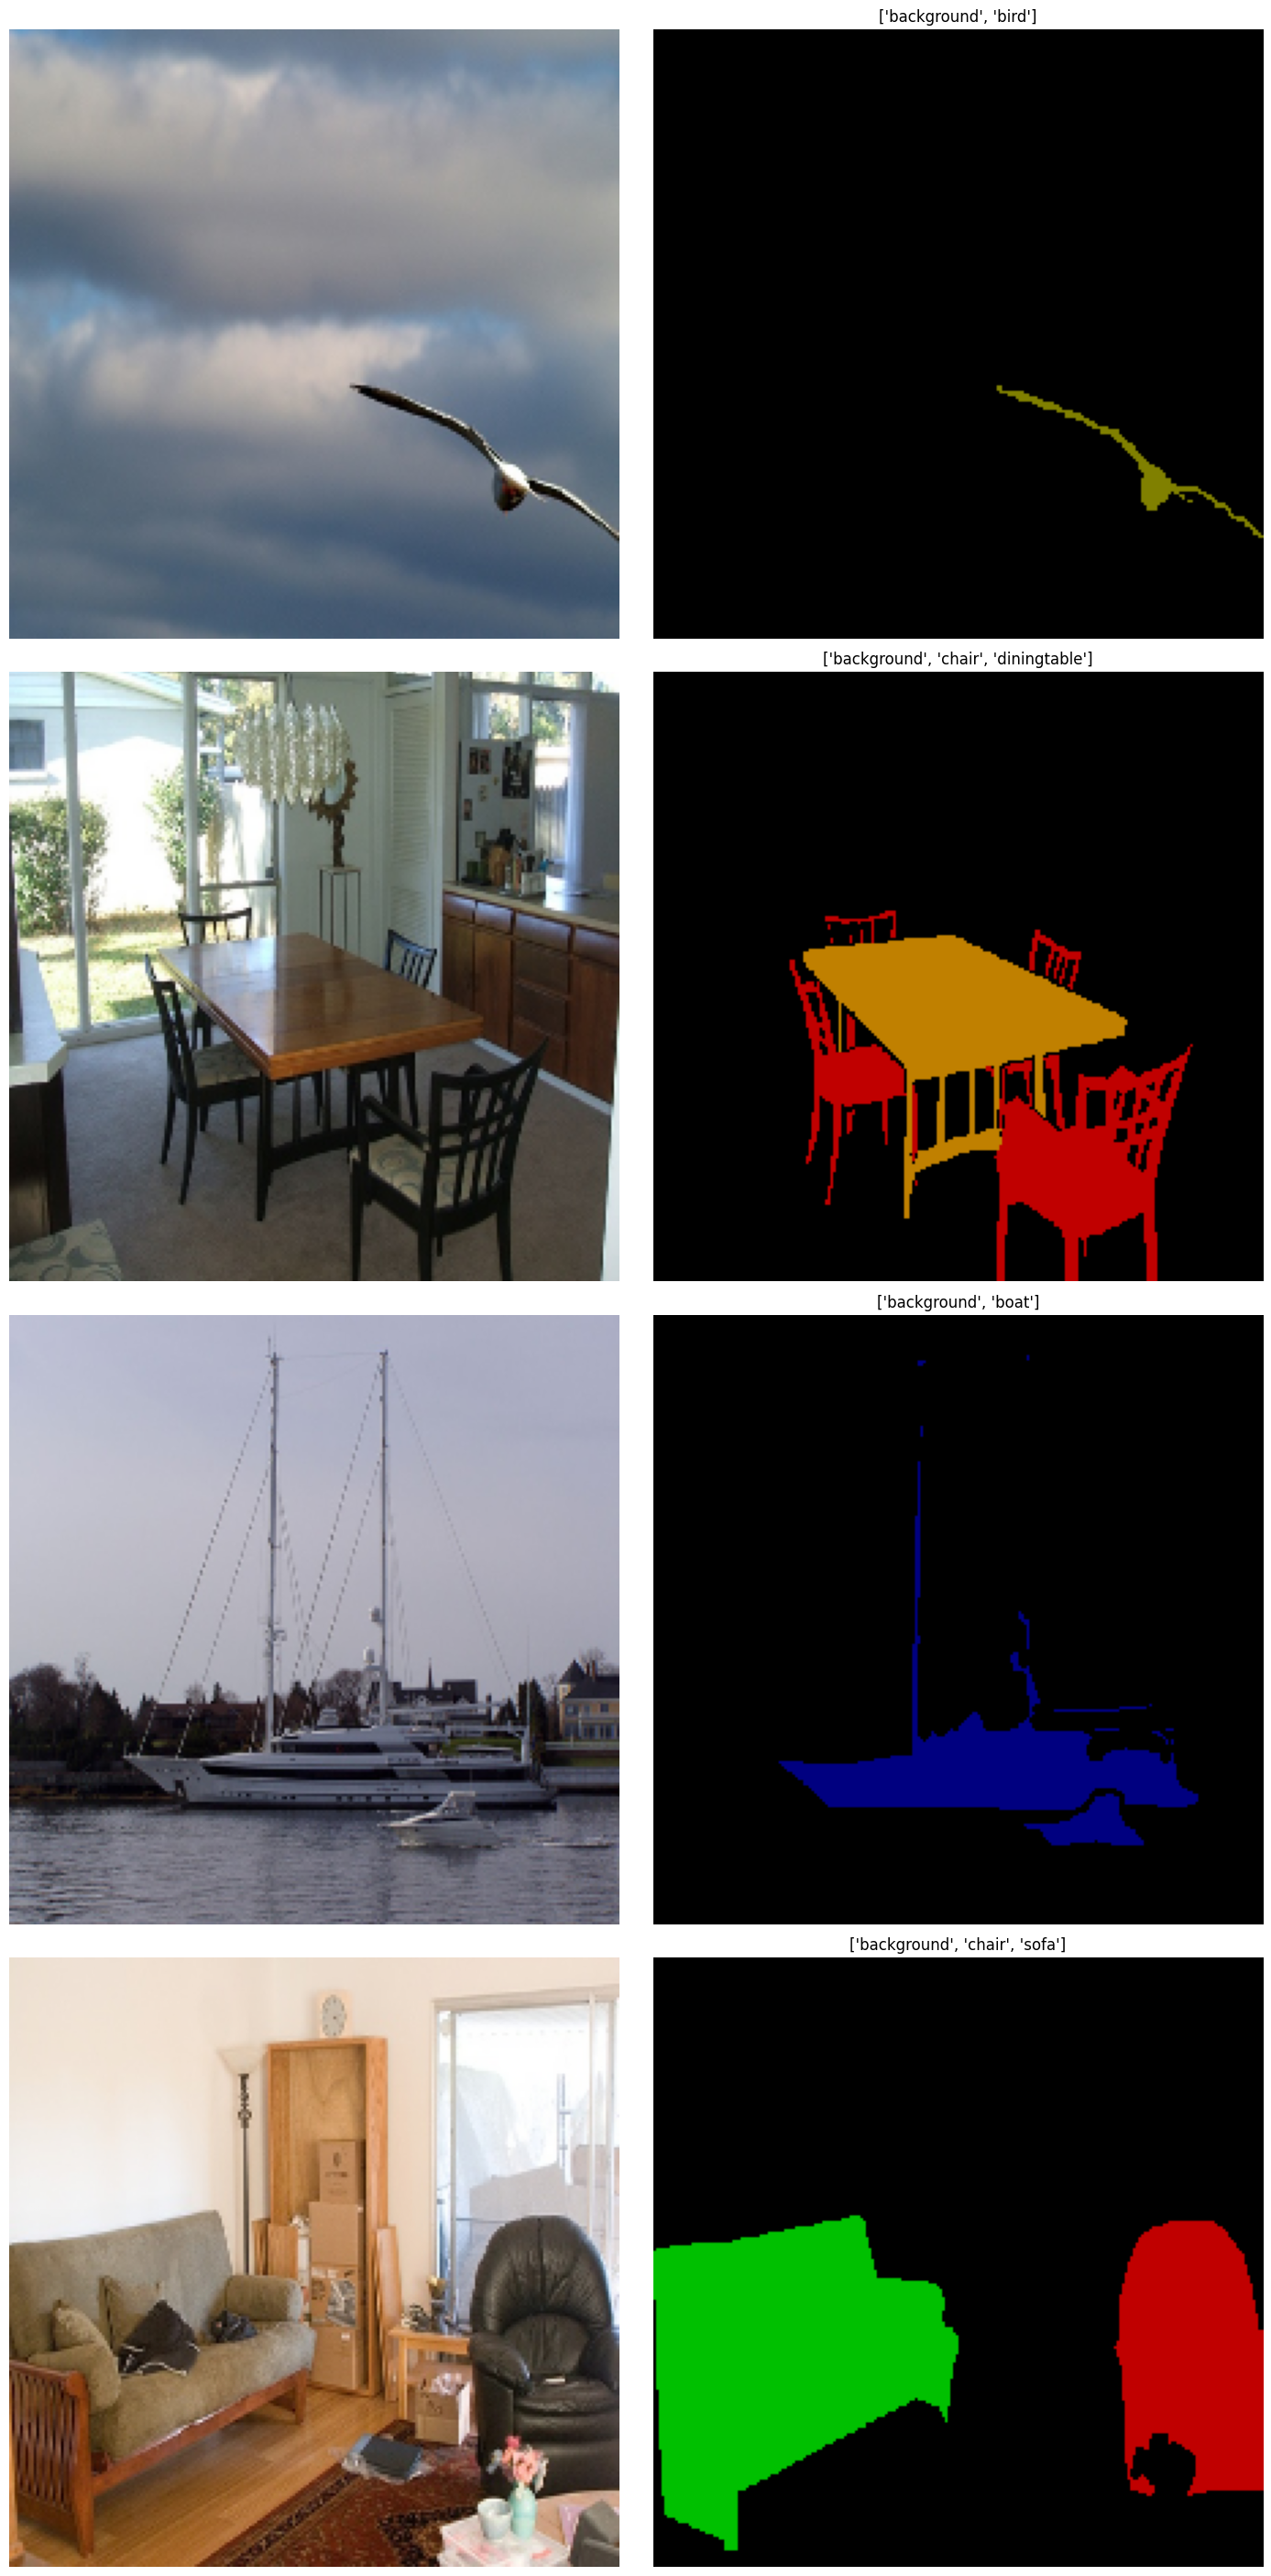

In [3]:
########### 데이터 시각화
import matplotlib.pyplot as plt


def draw_mask(images, masks, outputs=None, plot_size=4):
    def color_mask(image, target):
        m = target.squeeze().numpy().astype(np.uint8)
        cm = np.zeros_like(image, dtype=np.uint8)
        
        for i in range(1, 21):
            cm[m == i] = train_dataset.categories[str(i)]["color"]
        
        classes = [train_dataset.categories[str(idx)]["class"] for idx in np.unique(m)]
        return cm, classes
        
    col = 3 if outputs is not None else 2
    figsize = 20 if outputs is not None else 28
    fig, ax = plt.subplots(plot_size, col, figsize=(14, figsize), constrained_layout=True)
    
    for batch in range(plot_size):
        im = images[batch].numpy().transpose(1, 2, 0)
        ax[batch][0].imshow(im)
        ax[batch][0].axis("off")
   
        cm, classes = color_mask(im, masks[batch])
        ax[batch][1].set_title(classes)
        ax[batch][1].imshow(cm)
        ax[batch][1].axis("off")

        if outputs is not None:
            cm, classes = color_mask(im, outputs[batch])
            ax[batch][2].set_title(classes)
            ax[batch][2].imshow(cm)
            ax[batch][2].axis("off")


images, masks = next(iter(train_dataloader))
draw_mask(images, masks, plot_size=4)

In [5]:
########### FCN 모델 선언
from torch import nn
from torch import optim
from torchvision.models import segmentation


num_classes = 21
device = "mps" if torch.backends.mps.is_available() and torch.backends.mps.is_built() else "cpu"

# device = "cuda" if torch.cuda.is_available() else "cpu"
model = segmentation.fcn_resnet50(
    weight="FCN_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1",
    num_classes=21
).to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.SGD(params, lr=0.001, momentum=0.9, weight_decay=0.0005)
criterion = nn.CrossEntropyLoss()

In [7]:
########### 모델 학습
for epoch in range(30):
    model.train()
    cost = 0.0

    for images, targets in train_dataloader:
        images = images.to(device)
        targets = targets.to(device)

        output = model(images)
        output = output["out"].permute(0, 2, 3, 1).contiguous().view(-1, num_classes)
        targets = targets.permute(0, 2, 3, 1).contiguous().view(-1)

        loss = criterion(output, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        cost += loss
    cost = cost / len(train_dataloader)
    print(f"Epoch : {epoch+1:4d}, Cost : {cost:.3f}")

/opt/homebrew/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch :    1, Cost : 171382882304.000
Epoch :    2, Cost : 908450988032.000
Epoch :    3, Cost : 14187143102464.000
Epoch :    4, Cost : 137163194761216.000
Epoch :    5, Cost : 303321361416192.000
Epoch :    6, Cost : 2620991444353024.000
Epoch :    7, Cost : 4547142005817344.000
Epoch :    8, Cost : 27830335811092480.000
Epoch :    9, Cost : 82416170392616960.000
Epoch :   10, Cost : 89995782647709696.000
Epoch :   11, Cost : 89535095865606144.000
Epoch :   12, Cost : 88410724967120896.000
Epoch :   13, Cost : 87731140881809408.000
Epoch :   14, Cost : 86708904305623040.000
Epoch :   15, Cost : 86372273358897152.000
Epoch :   16, Cost : 85050333964795904.000


KeyboardInterrupt: 

In [ ]:
with torch.no_grad():
    model.eval()
    images, masks = next(iter(test_dataloader))
    outputs = model(images.to(device))["out"]
    outputs = outputs.argmax(axis=1).to("cpu")
    draw_mask(images, masks, outputs, 4)

In [ ]:
from collections import defaultdict


def calculate_iou(targets, outputs, ious, class_count, num_classes=21):
    for i in range(num_classes):
        intersection = np.float32(np.sum((outputs == targets) * (targets == i)))
        union = np.sum(targets == i) + np.sum(outputs == i) - intersection
        if union > 0:
            ious[i] += intersection / union
            class_count[i] += 1
    return ious, class_count


ious = np.zeros(21)
class_count = defaultdict(int)
with torch.no_grad():
    model.eval()
    for images, targets in test_dataloader:
        images = images.to(device)
        outputs = model(images)["out"].permute(0, 2, 3, 1).detach().to("cpu").numpy()
        targets = targets.permute(0, 2, 3, 1).squeeze().detach().to("cpu").numpy()
        outputs = outputs.argmax(-1)

        ious, class_count = calculate_iou(targets, outputs, ious, class_count, 21)

miou = 0.0
for idx in range(1, 21):
    miou += ious[idx] / class_count[idx]
miou /= 20
print(f"mIoU 계산 결과 : {miou}")